# Analytics

This notebook analyzes poker hand logs with improved code organization.

## Architecture
- `poker_utils.py`: Utility functions (card parsing, position detection)
- `poker_data.py`: Data loading and hand parsing
- `poker_stats.py`: Statistical analysis calculations
- `poker_viz.py`: Visualization and reporting

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Import custom modules
import poker_data
import poker_stats
import poker_viz
import poker_utils

from poker_data import PokerDataLoader, HandParser, PlayerMapper
from poker_stats import PlayerStatistics, AllInAnalyzer, RangeAnalyzer
from poker_viz import RangeVisualizer, StatisticsReporter
from poker_utils import parse_player_string

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [12]:
# ============================================================================
# ANALYSIS CONFIGURATION - Edit these variables to customize your analysis
# ============================================================================

# Player to analyze for positional stats (Section 6)
# Options: Any player name, or None for most active player
POSITIONAL_PLAYER = "jho"  # Set to None to auto-select most active player

# Player to analyze for all-in EV (Section 5)
# Options: Any player name, or None to show all players
ALLIN_PLAYER = "jho"  # Set to None to show all players

# Player to generate range chart for (Section 7)
# Options: Any player name from the available players
RANGE_CHART_PLAYER = "jho"

print("✓ Configuration loaded")
print(f"  • Positional Analysis: {POSITIONAL_PLAYER or 'Most Active Player'}")
print(f"  • All-In EV Analysis: {ALLIN_PLAYER or 'All Players'}")
print(f"  • Range Chart: {RANGE_CHART_PLAYER}")

✓ Configuration loaded
  • Positional Analysis: jho
  • All-In EV Analysis: jho
  • Range Chart: jho


## 1. Load Data

In [13]:
# Initialize data loader
loader = PokerDataLoader(data_dir='data/log', ledger_dir='data/ledger')

# Load log data
raw_data = loader.load_log_data()
raw_data.head(10)

Loading 0101_logdata.csv...
Loading 0103_logdata.csv...
Loading 1230_logdata.csv...
Loading 1231_logdata.csv...

Total entries: 62,714
Date range: 2025-12-30 09:46:25.557000+00:00 to 2026-01-03 12:00:00+00:00


,entry,at,order,source_file
0,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:25.557000+00:00,176708798555700,1230_logdata.csv
1,"""LIT2 @ Mw0SATaN53"" bets 6000",2025-12-30 09:46:27.945000+00:00,176708798794500,1230_logdata.csv
2,"""zxc @ uaMcxyz0Rj"" calls 6000",2025-12-30 09:46:29.851000+00:00,176708798985100,1230_logdata.csv
3,"""jho @ t3NhL8TnYz"" calls 6000",2025-12-30 09:46:36.922000+00:00,176708799692200,1230_logdata.csv
4,"Turn: 6♣, 8♥, 5♣ [8♣]",2025-12-30 09:46:37.728000+00:00,176708799772800,1230_logdata.csv
5,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:39.109000+00:00,176708799910900,1230_logdata.csv
6,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:42.547000+00:00,176708800254700,1230_logdata.csv
7,"""LIT2 @ Mw0SATaN53"" checks",2025-12-30 09:46:43.635000+00:00,176708800363500,1230_logdata.csv
8,"River: 6♣, 8♥, 5♣, 8♣ [2♣]",2025-12-30 09:46:44.460000+00:00,176708800446000,1230_logdata.csv
9,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:46.893000+00:00,176708800689300,1230_logdata.csv


## 2. Parse Hands

In [14]:
# Parse all hands from log data
hands = HandParser.parse_hands(raw_data)
print(f"✓ Parsed {len(hands):,} complete poker hands")

✓ Parsed 3,435 complete poker hands


## 3. Player Identity Mapping

Edit the dictionary below to merge multiple player IDs into unified names.

In [15]:
# Get all unique player IDs
all_player_ids = set()
for hand in hands:
    all_player_ids.update(hand['players'].keys())

# Display unique players
print("📋 ALL UNIQUE PLAYER IDs FOUND:")
print("="*80)
print(f"{'ID':<20} | Username")
print("-"*80)

initial_mapping = {}
for player_str in sorted(all_player_ids):
    player_id, username = parse_player_string(player_str)
    initial_mapping[player_id] = username
    print(f"{player_id:<20} | {username}")

print("\n✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs:")

📋 ALL UNIQUE PLAYER IDs FOUND:
ID                   | Username
--------------------------------------------------------------------------------
xswHkyUXqL           | 9292
Ek559oOV8c           | 9917.
xpbZinNQx9           | 9917..
eLlYR19TDN           | Black
g0FfVCh6gI           | Justin
Mw0SATaN53           | LIT
thyyJUIpI9           | LIT
3jIWLYiXzx           | LIT2
Mw0SATaN53           | LIT2
xswHkyUXqL           | O9O9
xswHkyUXqL           | Z9Z9
xswHkyUXqL           | Z9z9
e2LT3dd3Tx           | black
t3NhL8TnYz           | jho
uaMcxyz0Rj           | zxc
cIaXP7lyE_           | zxc2
u341hEhZ9E           | zxc2

✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs:


In [16]:
# EDITABLE PLAYER MAPPING
# Map all player IDs to unified player names

player_id_mapping = {
    # LIT (sometimes appears as LIT or LIT2)
    "3jIWLYiXzx": "LIT",
    "thyyJUIpI9": "LIT",
    "Mw0SATaN53": "LIT",

    # zxc (including zxc2)
    "u341hEhZ9E": "zxc",
    "uaMcxyz0Rj": "zxc",
    "cIaXP7lyE_": "zxc",
    "HwYscE0DK2": "zxc",

    # black (including BM and 블몬)
    "e2LT3dd3Tx": "black",
    "eLlYR19TDN": "black",
    "6HmBRHGZcY": "black",
    "P2jS_dvDyj": "black",
    "LEYWZ_6-T9": "black",

    # sh
    "xpbZinNQx9": "sh",
    "Ek559oOV8c": "sh",
    "q21UtMebOx": "sh",

    # 9292 (including 92929)
    "xswHkyUXqL": "9292",
    "f_ZuasHCJZ": "9292",
    "exrnYGgrmM": "9292",

    # jho
    "t3NhL8TnYz": "jho",

    # Justin
    "g0FfVCh6gI": "Justin",
    "uhEB5tfxOo": "Justin",
}

# Add any missing IDs with their default usernames
for player_id, username in initial_mapping.items():
    if player_id not in player_id_mapping:
        player_id_mapping[player_id] = username

# Initialize player mapper
player_mapper = PlayerMapper(player_id_mapping)
player_mapper.build_mapping(all_player_ids)

print(f"✓ Player mapping loaded with {len(player_id_mapping)} ID entries")

# Show merged accounts
merged = player_mapper.get_merged_accounts()
if merged:
    print(f"\n🔗 MERGED ACCOUNTS (multiple IDs → same username):")
    for username, ids in merged.items():
        print(f"   {username}: {', '.join(ids)}")

✓ Player mapping loaded with 21 ID entries

🔗 MERGED ACCOUNTS (multiple IDs → same username):
   LIT: 3jIWLYiXzx, thyyJUIpI9, Mw0SATaN53
   zxc: u341hEhZ9E, uaMcxyz0Rj, cIaXP7lyE_, HwYscE0DK2
   black: e2LT3dd3Tx, eLlYR19TDN, 6HmBRHGZcY, P2jS_dvDyj, LEYWZ_6-T9
   sh: xpbZinNQx9, Ek559oOV8c, q21UtMebOx
   9292: xswHkyUXqL, f_ZuasHCJZ, exrnYGgrmM
   Justin: g0FfVCh6gI, uhEB5tfxOo


## 4. Player Statistics

In [17]:
# Load ledger data
ledger_data = loader.load_ledger_data()

# Calculate player statistics
stats_calculator = PlayerStatistics(player_mapper)
player_stats = stats_calculator.calculate_from_ledger(ledger_data, hands)

# Display rankings
StatisticsReporter.print_player_rankings(player_stats)

Loading 0101_ledger.csv...
Loading 0103_ledger.csv...
Loading 1216_ledger.csv...
Loading 1217.1_ledger.csv...
Loading 1217.2_ledger.csv...
Loading 1218_ledger.csv...
Loading 1221_ledger.csv...
Loading 1222_ledger.csv...
Loading 1224_ledger.csv...
Loading 1226_ledger.csv...
Loading 1227_ledger.csv...
Loading 1228_ledger.csv...
Loading 1229_ledger.csv...
Loading 1230_ledger.csv...
Loading 1231_ledger.csv...
Total ledger entries: 291

PLAYER PERFORMANCE RANKINGS (FROM LEDGER DATA)
Net Profit = Sum of all session 'net' values from ledger
        total_buy_in  total_buy_out  net_profit  win_rate    roi
jho          6100000      9407705.0     3307705     19.71  54.22
zxc          8607405     11729918.0     3122513     21.07  36.28
LIT          6837662      8735702.0     1898040     26.61  27.76
black       12364611     13396641.0     1032030     28.76   8.35
sh           4504762      2719748.0    -1785014     25.49 -39.63
Justin       5500000      3581871.0    -1918129     28.60 -34.88
9292 

## 5. Hand Range Analysis

Displays a range chart for the player configured in the Configuration section.

In [18]:
# Calculate positional statistics
positional_stats = stats_calculator.calculate_positional_stats(hands)

# Determine which player to display
if POSITIONAL_PLAYER and POSITIONAL_PLAYER in positional_stats:
    selected_player = POSITIONAL_PLAYER
else:
    # Use most active player if not specified or not found
    selected_player = player_stats.index[player_stats['hands_played'].argmax()]
    if POSITIONAL_PLAYER:
        print(f"⚠️  Player '{POSITIONAL_PLAYER}' not found. Using most active player instead.\n")

StatisticsReporter.print_positional_analysis(positional_stats, selected_player)

print(f"\n✓ Positional data calculated for all {len(positional_stats)} players")


🎯 POSITIONAL ANALYSIS

Positional Stats for jho:
--------------------------------------------------------------------------------
Position  Hands  Win Rate %  Invested     Won      Net
      BB    353        28.0   5674520 4361528 -1312992
     BTN    352        21.9   4540631 4781058   240427
      SB    308        16.9   3812069 1735947 -2076122
     UTG    270        14.8   2531825 1788700  -743125
      MP    124         8.1    827236  413550  -413686
      CO     33        12.1    707400  286400  -421000
 Unknown     16        31.2     97500  166500    69000
    MP+1      3         0.0     57400       0   -57400
   UTG+1      2        50.0    234200  474000   239800

💡 POSITIONAL INSIGHTS for jho:
   • Most Profitable Position: BTN (Net: $240,427)
   • Least Profitable Position: SB (Net: $-2,076,122)

✓ Positional data calculated for all 7 players


## 6. Positional Analysis

In [19]:
# Calculate hand ranges and create matrix
range_analyzer = RangeAnalyzer(player_mapper)
player_ranges = range_analyzer.collect_showdown_ranges(hands)
hand_matrix, ranks = RangeAnalyzer.create_hand_matrix()

print(f"✓ Range data calculated for {len(player_ranges)} players with showdown data")
print(f"\nPlayers with showdown data:")
for player in sorted(player_ranges.keys()):
    showdown_count = sum(player_ranges[player].values())
    print(f"   • {player}: {showdown_count} showdowns")

✓ Range data calculated for 7 players with showdown data

Players with showdown data:
   • 9292: 334 showdowns
   • Justin: 162 showdowns
   • LIT: 186 showdowns
   • black: 198 showdowns
   • jho: 91 showdowns
   • sh: 95 showdowns
   • zxc: 116 showdowns


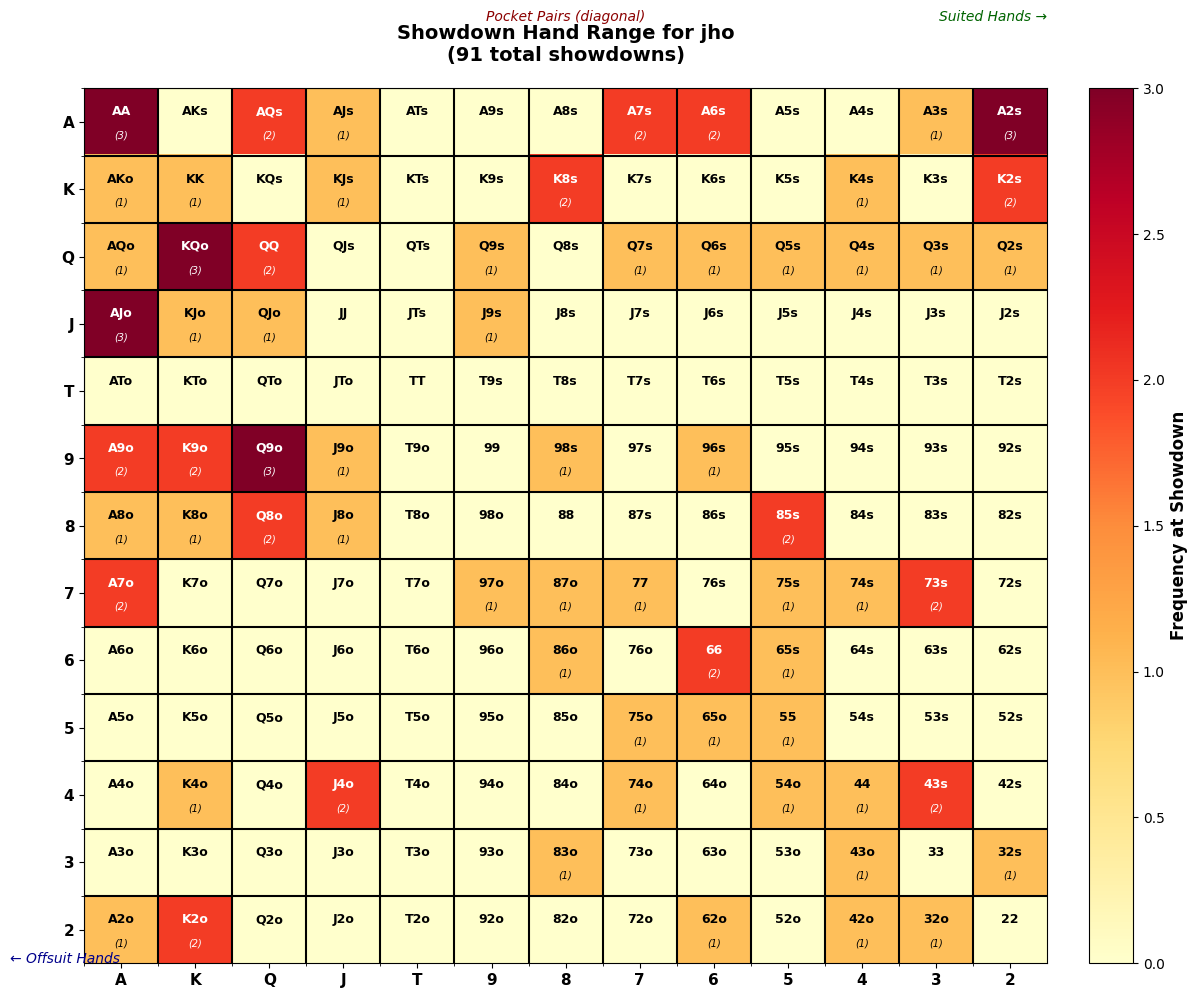


🃏 HAND RANGE ANALYSIS
Generating range chart for: jho
Total showdowns: 91


In [20]:
# Use configured player for range chart
if RANGE_CHART_PLAYER in player_ranges:
    freq_matrix = RangeVisualizer.plot_hand_range_heatmap(
        RANGE_CHART_PLAYER,
        player_ranges[RANGE_CHART_PLAYER],
        hand_matrix,
        ranks
    )
    
    StatisticsReporter.print_range_analysis(player_ranges, RANGE_CHART_PLAYER)
else:
    print(f"Player '{RANGE_CHART_PLAYER}' not found or has no showdown data.")
    print(f"\nAvailable players with showdown data:")
    for player in sorted(player_ranges.keys()):
        print(f"   • {player}")